# Field Reversed Configuration (FRC) Simulations

The FRC formed through an RMF can be characterized by two important dimensionless parameters, $\lambda=R/\delta$, where $\delta=(2\eta /\mu_o \omega)^{1/2}$ is the classical skin depth, and by $\gamma=\omega_{ce}/\nu_{ei}$, where $\nu_{ei}=\eta(ne^2/m_e)$ is the electron-ion collision frequency. In term of the system parameters, these two parameters can be expressed as

$$ \lambda = R \left(\frac{\mu_o\omega}{2\eta}\right)^{1/2} $$,

$$ \gamma = \frac{1}{e}\left(\frac{B_\omega}{n\eta}\right) $$.

The magnitude of the external-driving field must exceed a certain critical value before much current is driven in the plasma column.

The measure of the current drive is the parameter $\alpha$, which is defined as the ratio of the driven current divided by the current obtained if all of the electrons rotate synchronously with the RMF.

$$ \alpha = \frac{2}{\mu_o n e \omega R^2}\left(B_z(r=R) - B(r=0) \right) $$

In [12]:
# Do all needed imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vtk
import os
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.tri as tri
import re

%matplotlib inline

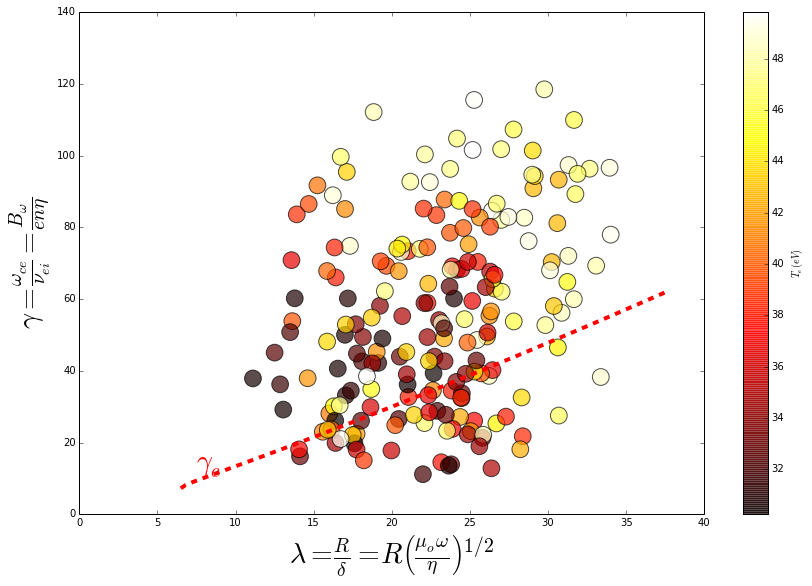

In [13]:
number = 200 # Sample size

def calRatio(w, Bw, Te):
    mu_o = np.pi*4.e-7
    e = 1.602e-19

    n = 1.0e20
    R = 0.03
    loglambda = 10.

    eta = 5.2e-5*loglambda/(Te)**1.5
    #eta = 1.65e-9*loglambda/(Te/1.e3)**1.5

    gamma = Bw/e/n/eta
    lmbda = R*np.sqrt(0.5*mu_o*w/eta)

    return gamma, lmbda

def gammaCritical(lbd):
    return 1.12*lbd*(1.0+0.12*(lbd-6.5)**0.4)

def getSelectionInRange(var, rmin, rmax, sample):
    a = np.where(var>rmin)
    b = np.where(var<rmax)
    intersec = np.intersect1d(a,b)

    if(sample<len(intersec)):
        randSample = np.random.randint(len(intersec), size=sample)
        res = intersec[randSample]
    else:
        res = intersec

    return res

omega = np.zeros(number)
Bomega= np.zeros(number)
Temp  = np.zeros(number)
lam   = np.zeros(number)
gam   = np.zeros(number)
gol   = np.zeros(number)

np.random.seed(4)
for k in range(number):
    omega[k] = np.random.uniform(2*np.pi*1.e5,2*np.pi*5.e5)
    Bomega[k]= np.random.uniform(5.e-4,30.e-4)
    Temp[k]  = np.random.uniform(30.,50.)
    gam[k], lam[k]   = calRatio(omega[k], Bomega[k], Temp[k])
    gol[k] = gam[k]/lam[k]

plt.figure(figsize=(14,9))
sc = plt.scatter(lam, gam, c=Temp, cmap="hot", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$T_e (eV)$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

For each of the points in the scatter plot an Apollo simulations was run.

In [79]:
time = 51
component = 0
d = np.loadtxt('simulation_values.txt')

reader = vtk.vtkXMLUnstructuredGridReader()

# this function extracts the RMF frequency, RMF field magnitude, and the electron temperature at initialization
def getSimulationParameters(filename):
    f=open(filename)
    lines = f.readlines()
    om = re.findall("\d+\.\d+",lines[2])
    Bo = re.findall("\d+\.\d+",lines[3])
    Te = re.findall("\d+\.\d+",lines[4])
    
    return float(om[0]), float(Bo[0]), float(Te[0])
    

# get a list of all sub-directories in thedir
thedir  = '/home/sousae/simulationsApollo/rmf_frc/dataAnalysis'
subdirs = [ name for name in os.listdir(thedir) if os.path.isdir(os.path.join(thedir, name)) ]
if '.ipynb_checkpoints' in subdirs: subdirs.remove('.ipynb_checkpoints') ### I get this weird sting in there somehow

#################### this is used to get the dimensions of the dataset per output file #####
folder = 'gammaOverGamma_crit_0.804947683677'
filename = folder+'/frc2d_2Fluid_'+str('%03d' % 0)+'.vtu'
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(filename)
reader.Update()
size = len( vtk_to_numpy( reader.GetOutput().GetPointData().GetArray(component) ) )
############################################################################################

dataB = np.zeros((size,time))
dataR = np.zeros((size,time))
minBz= np.zeros(time)

frc = np.zeros((len(subdirs),12))

# Loop over all sample test cases
for s in range(len(subdirs)):
    # get the values of omega, b_omega, and Te for this sample
    frc[s,0], frc[s,1], frc[s,2] = getSimulationParameters(subdirs[s]+'/frc2d.pin')
    #calculate gamma, lambda and gamma/gammaCritical
    frc[s,4], frc[s,3]   = calRatio(frc[s,0], frc[s,1], frc[s,2])
    frc[s,5] = frc[s,4]/gammaCritical(frc[s,3])
    
    # loop over all time slices
    for k in range(time):
        filename = subdirs[s]+'/frc2d_2Fluid_'+str('%03d' % k)+'.vtu'
        reader.SetFileName(filename)
        reader.Update()
        dataB[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(15)) # Bz
        dataR[:,k] = vtk_to_numpy(reader.GetOutput().GetPointData().GetArray(0)) # Bz
        minBz[k]  = min(dataB[:,k])
        
    ### Do a SVD
    U, sB, V = np.linalg.svd(dataB, full_matrices=False)
    U, sR, V = np.linalg.svd(dataR, full_matrices=False)
    
    ### Get the first singular value for Bz SVD
    frc[s,6] = sB[0]
    frc[s,7] = sB[0]/sB.sum()
    
    ### Get the first singular value for rho_e SVD
    frc[s,8] = sR[0]
    frc[s,9] = sR[0]/sR.sum()
    
    frc[s,10] = dataB.min()
    frc[s,11] = (1. if dataB.min() < 0. else 0.)
#plt.figure(figsize=(14,9))
#plt.subplot(421), plt.plot(s/sum(s),'bo', markersize=12)
#plt.subplot(423), plt.plot(U[:,0],'b',lw=2)
#plt.subplot(425), plt.plot(U[:,1],'r',lw=2)
#plt.subplot(427), plt.plot(U[:,2],'g',lw=2)

#plt.subplot(422), plt.plot(minBz,lw=2)
#plt.subplot(422), plt.plot(plasmaFreqe,'r',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqi,'g',lw=2)
#plt.subplot(422), plt.plot(plasmaFreqp,'m',lw=2)
#plt.subplot(424), plt.plot(V[0,:],'b',lw=2)
#plt.subplot(426), plt.plot(V[1,:],'r',lw=2)
#plt.subplot(428), plt.plot(V[2,:],'g',lw=2)
print('Done.')

Done.


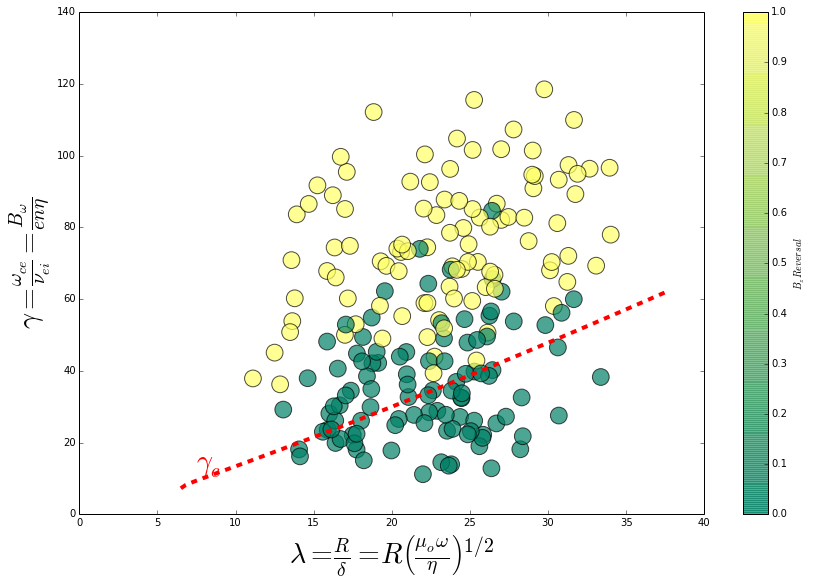

In [90]:
plt.figure(figsize=(14,9))
sc = plt.scatter(frc[:,3], frc[:,4], c=frc[:,11], cmap="summer", alpha=0.7,s=280)

cb = plt.colorbar(sc, label=r'$B_z Reversal$')
plt.legend()
plt.xlabel(r"$\lambda = \frac{R}{\delta} = R\left(\frac{\mu_o\omega}{\eta}\right)^{1/2}$",fontsize=28)
plt.ylabel(r"$\gamma = \frac{\omega_{ce}}{\nu_{ei}} = \frac{B_\omega}{en\eta}$",fontsize=28)
#plt.plot([0.2*pi,3.3],[1.,1.],'k--',lw=2.)
#plt.xlim(0.2*pi,3.3)

xx = np.linspace(6.5,37.5,100)
yy = gammaCritical(xx)
plt.plot(xx,yy,'r--',lw=4.)
plt.text(7.5,12.,r"$\gamma_c$",fontsize=28,color='red')

In [85]:
import pandas as pd
df = pd.DataFrame(frc, columns=['omega', 'Bomega', 'Te', 'lambda', 'gamma', 'gammaOverCrit', 'svd_bz', 'svd_bz_per', 'svd_rho', 'svd_rho_perc', 'minBz', 'reversal'])

In [86]:
df.head()

,omega,Bomega,Te,lambda,gamma,gammaOverCrit,svd_bz,svd_bz_per,svd_rho,svd_rho_perc,minBz,reversal
0,1.819520e+06,0.002475,39.755399,22.270760,74.462702,2.192357,1.340145,0.671579,9.052706e-08,0.998264,-0.000142,1.0
1,1.776732e+06,0.001087,41.263065,22.630367,34.579846,0.999529,1.227496,0.788111,9.052708e-08,0.999077,0.000195,0.0
2,1.406154e+06,0.001316,43.463929,20.932579,45.268200,1.431253,1.259377,0.755770,9.052774e-08,0.998931,0.000097,0.0
3,2.920815e+06,0.001964,35.883341,26.129506,50.682850,1.241678,1.325446,0.705105,9.052385e-08,0.998474,-0.000382,1.0
4,1.891322e+06,0.002217,35.073593,20.669379,55.271993,1.773163,1.328115,0.691692,9.052493e-08,0.998299,-0.000007,1.0


In [ ]:
np.savetxt()